In [3]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Input, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import pandas as pd
import nltk
from matplotlib import pyplot as plt
%matplotlib inline

## Data Exploration

In [5]:
train = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
test_labels = pd.read_csv("data/test_labels.csv")

In [6]:
len(train), len(test_data)

(159571, 153164)

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
train["id"].head()

0    0000997932d777bf
1    000103f0d9cfb60f
2    000113f07ec002fd
3    0001b41b1c6bb37e
4    0001d958c54c6e35
Name: id, dtype: object

In [9]:
train.isnull().values.any()

False

In [10]:
test_data.isnull().values.any()

False

In [11]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [12]:
test_data.isnull().any()

id              False
comment_text    False
dtype: bool

In [13]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_y = train[classes].values
train_x = train["comment_text"]
test_x = test_data["comment_text"]

In [14]:
train_x.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [15]:
test_x.head()

0    Yo bitch Ja Rule is more succesful then you'll...
1    == From RfC == \n\n The title is fine as it is...
2    " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3    :If you have a look back at the source, the in...
4            I don't anonymously edit articles at all.
Name: comment_text, dtype: object

## Data Preprocessing

In [16]:
max_words = 20000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(train_x))

In [17]:
tokenized_train_x = tokenizer.texts_to_sequences(train_x)
tokenized_test_x = tokenizer.texts_to_sequences(test_x)

In [18]:
len(tokenized_train_x), len(tokenized_test_x)

(159571, 153164)

In [19]:
maxlen = 200
X_train = pad_sequences(tokenized_train_x, maxlen = maxlen)
X_test = pad_sequences(tokenized_test_x, maxlen = maxlen)

In [20]:
len(X_train), len(X_test)

(159571, 153164)

In [21]:
X_train[23]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [22]:
total_num_words = [len(one_comment) for one_comment in tokenized_train_x]
#total_num_words

<function matplotlib.pyplot.show(*args, **kw)>

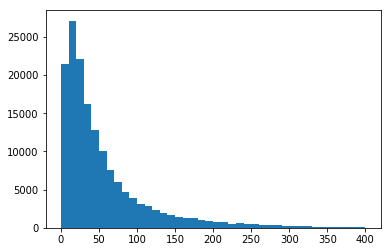

In [23]:
plt.hist(total_num_words, bins = np.arange(0,410,10))
plt.show

## Final Preprocessed Data

In [25]:
train_x[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [26]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,